In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df.pop('Name')
df.pop('PassengerId')
df.pop('Ticket')
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

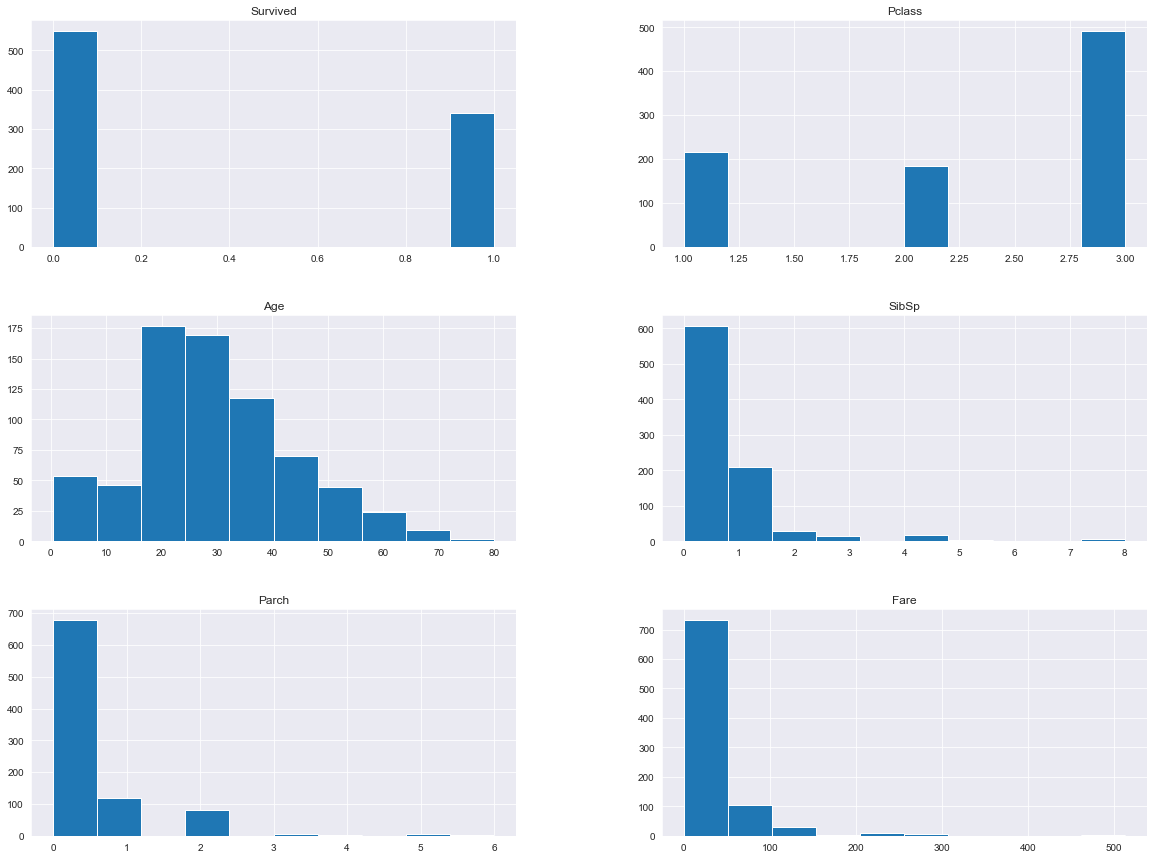

In [6]:
df.hist(figsize=(20,15))

In [7]:
df['CabinLetter'] = df.Cabin.apply(lambda x: x[0] if pd.notnull(x) else 'UnK')
df.pop('Cabin')
df['Age'].fillna(value=df['Age'].mean(), inplace=True)
df['Embarked'].fillna(value=df['Embarked'].mode().iloc[0], inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinLetter
0,0,3,male,22.0,1,0,7.2500,S,UnK
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,S,UnK
3,1,1,female,35.0,1,0,53.1000,S,C
4,0,3,male,35.0,0,0,8.0500,S,UnK


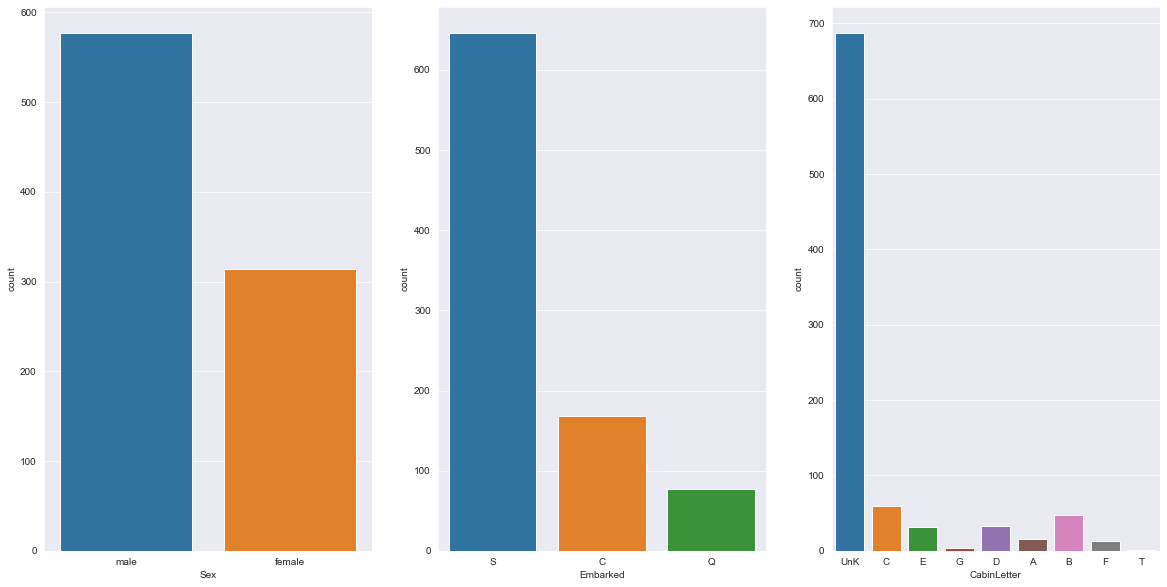

In [8]:
i = 1
plt.figure(figsize=(20,10))
for k in df:
    if df[k].dtypes == 'object':
        plt.subplot(1, 3, i)
        sns.countplot(df[k])
        i += 1

array([[<AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>],
       [<AxesSubplot:title={'center':'Parch'}>,
        <AxesSubplot:title={'center':'Fare'}>]], dtype=object)

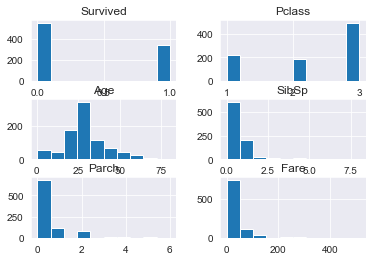

In [9]:
df.hist()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

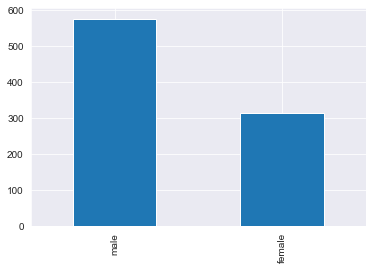

In [10]:
df.Sex.value_counts().plot(kind = 'bar')
df.groupby('Sex').Survived.mean()

In [11]:
shuffle_data = df.sample(frac=1)
train_size = int(0.7 * len(df))
train_set = shuffle_data[:train_size]
test_set = shuffle_data[train_size:]
train_y = train_set.pop("Survived")
test_y = test_set.pop("Survived")

In [12]:
feature_columns = []
for k in train_set:
    if train_set[k].dtypes == 'object':
        vocabulary = train_set[k].unique() 
        feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(k, vocabulary))
    else:
        feature_columns.append(tf.feature_column.numeric_column(k, dtype = tf.float32))

In [13]:
def make_input_fn(data_df, label_df, num_epochs = 10, shuffle = True, batch_size = 32):
  def input_function(): 
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df)) 
    if shuffle:
      ds = ds.shuffle(1000)  
    ds = ds.batch(batch_size).repeat(num_epochs)  
    return ds  
  return input_function  

In [14]:
train_input_fun = make_input_fn(train_set, train_y)
test_input_fun = make_input_fn(test_set, test_y)
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

linear_est.train(train_input_fun)
results = linear_est.evaluate(test_input_fun)
clear_output()


In [15]:
print(results)

{'accuracy': 0.7761194, 'accuracy_baseline': 0.6007463, 'auc': 0.8230975, 'auc_precision_recall': 0.76679325, 'average_loss': 0.5336774, 'label/mean': 0.39925373, 'loss': 0.53556633, 'precision': 0.7473684, 'prediction/mean': 0.33531058, 'recall': 0.6635514, 'global_step': 200}


In [16]:
df.Sex.replace(('male', 'female'), (0, 1), inplace=True)
df.Embarked.replace(('S', 'C', 'Q'), (0, 1, 2), inplace=True)
df.CabinLetter.replace(('UnK', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'), range(9), inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinLetter
0,0,3,0,22.0,1,0,7.2500,0,0
1,1,1,1,38.0,1,0,71.2833,1,3
2,1,3,1,26.0,0,0,7.9250,0,0
3,1,1,1,35.0,1,0,53.1000,0,3
4,0,3,0,35.0,0,0,8.0500,0,0


<AxesSubplot:>

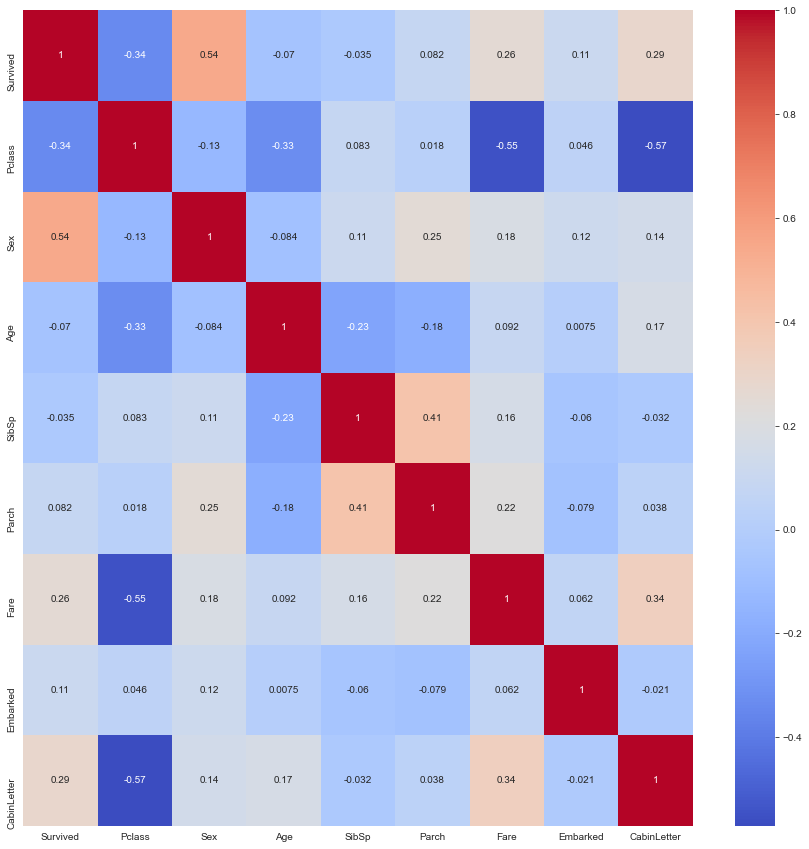

In [17]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [18]:
np.abs(df.corr()['Survived'].sort_values(ascending=False))

Survived       1.000000
Sex            0.543351
CabinLetter    0.287944
Fare           0.257307
Embarked       0.106811
Parch          0.081629
SibSp          0.035322
Age            0.069809
Pclass         0.338481
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Survived', ylabel='count'>

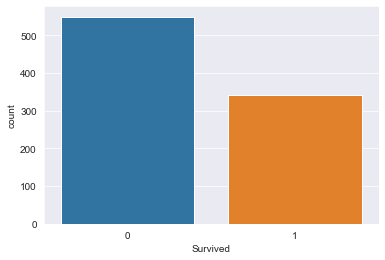

In [19]:
sns.countplot(df['Survived'])

In [20]:
# from sklearn.utils import resample, shuffle
# one = df[df['Survived']==1]
# zero = df[df['Survived']==0]

# upsample = resample(zero, replace=True, n_samples=one.shape[0])

# nndf = shuffle(pd.concat([upsample, one]))
# nndf.head()
nndf = df.copy(deep=True)

<AxesSubplot:xlabel='Survived', ylabel='count'>

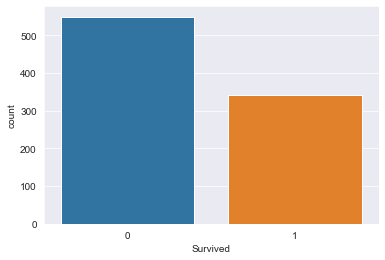

In [21]:
sns.countplot(nndf['Survived'])

In [22]:
nndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    int64  
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     891 non-null    int64  
 8   CabinLetter  891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB


In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

nny = nndf.pop('Survived')
ss = StandardScaler()

nnTrain, nnTest, nnTrain_y, nnTest_y = train_test_split(nndf, nny, test_size=0.2, stratify=nny)

nnTrain = ss.fit_transform(nnTrain)
nnTest = ss.transform(nnTest)

In [24]:
print(nnTrain.shape)
print(nnTest.shape)

(712, 8)
(179, 8)


In [25]:
nnmodel = keras.Sequential([keras.layers.Dense(4, activation='relu', input_dim=nnTrain.shape[1]),
                            keras.layers.Dense(2, activation='relu'),
                            keras.layers.Dense(1, activation='sigmoid')])
nnmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [26]:
nnmodel.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

In [27]:
test = nnmodel.fit(nnTrain, nnTrain_y, validation_split=0.1, batch_size=50, epochs=100, verbose=1)
clear_output()
nnmodel.evaluate(nnTest, nnTest_y)

6/6 [==============================] - 0s 2ms/step - loss: 0.4561 - accuracy: 0.8324


[0.45606765151023865, 0.832402229309082]

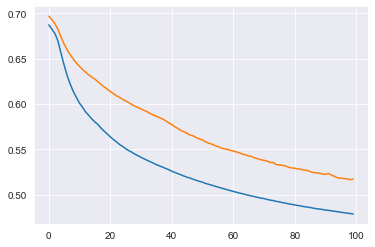

In [28]:
plt.plot(test.history['loss'])
plt.plot(test.history['val_loss'])

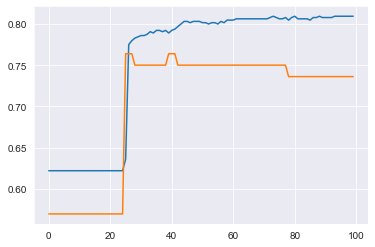

In [29]:
plt.plot(test.history['accuracy'])
plt.plot(test.history['val_accuracy'])

In [30]:
tdata = pd.read_csv('./data/test.csv')

In [31]:
def data_process(data):
    ss = StandardScaler()
    data.pop('Name')
    data.pop('PassengerId')
    data.pop('Ticket')
    data['CabinLetter'] = data.Cabin.apply(lambda x: x[0] if pd.notnull(x) else 'UnK')
    data.pop('Cabin')
    data['Age'].fillna(value=data['Age'].mean(), inplace=True)
    data['Embarked'].fillna(value=data['Embarked'].mode().iloc[0], inplace=True)
    data.Sex.replace(('male', 'female'), (0, 1), inplace=True)
    data.Embarked.replace(('S', 'C', 'Q'), (0, 1, 2), inplace=True)
    data.CabinLetter.replace(('UnK', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'), range(9), inplace=True)
    return data

In [32]:
tdata = data_process(tdata)

In [33]:
tdata.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinLetter
0,3,0,34.5,0,0,7.8292,2,0
1,3,1,47.0,1,0,7.0000,0,0
2,2,0,62.0,0,0,9.6875,2,0
3,3,0,27.0,0,0,8.6625,0,0
4,3,1,22.0,1,1,12.2875,0,0


In [34]:
tfdata = ss.transform(tdata)

In [35]:
res = nnmodel.predict(tfdata)

In [36]:
predictions = []
for x, i in enumerate(res):
    if i<0.5:
        predictions.append(0)
    elif i==np.nan:
        print(x)
    else:
        predictions.append(1)

In [37]:
ftest = pd.read_csv('./data/test.csv')
ftest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [38]:

ftest['Prediction'] = predictions

In [39]:
ftest.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prediction
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [40]:
dfn = ftest[['PassengerId', 'Prediction']]


In [41]:
dfn.to_csv (r'C:\Users\aaron\Desktop\export_dataframe.csv', index = False, header=True)

In [42]:
# submission = pd.DataFrame({
#         'PassengerId': test.PassengerId,
#         'Survived': prediction.Label
#     })
# submission.to_csv('submission.csv', index=False)

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['Lived', 'Died']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

    final = pd.concat(dfs, ignore_index=True)
    return final

In [44]:
result = run_exps(nnTrain, nnTrain_y, nnTest, nnTest_y)

LogReg
              precision    recall  f1-score   support

       Lived       0.86      0.86      0.86       110
        Died       0.78      0.77      0.77        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

RF
              precision    recall  f1-score   support

       Lived       0.88      0.91      0.90       110
        Died       0.85      0.81      0.83        69

    accuracy                           0.87       179
   macro avg       0.87      0.86      0.86       179
weighted avg       0.87      0.87      0.87       179

KNN
              precision    recall  f1-score   support

       Lived       0.89      0.89      0.89       110
        Died       0.83      0.83      0.83        69

    accuracy                           0.87       179
   macro avg       0.86      0.86      0.86       179
weighted avg       0.87      0.87      0.87       179

SVM
 

In [45]:
result.head()

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.004987,0.005983,0.797203,0.795437,0.797203,0.795297,0.832102,LogReg
1,0.004016,0.002990,0.811189,0.808027,0.811189,0.805955,0.832284,LogReg
2,0.002991,0.004987,0.760563,0.761537,0.760563,0.760899,0.838758,LogReg
3,0.002991,0.003013,0.845070,0.843045,0.845070,0.843316,0.874335,LogReg
4,0.002998,0.002990,0.816901,0.816852,0.816901,0.814107,0.841692,LogReg


In [46]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(nnTrain, nnTrain_y)
clear_output()

In [47]:
# print best parameter after tuning
print(grid.best_params_)
print(grid.best_score_)

# print how our model looks after hyper-parameter tuning
be = grid.best_estimator_

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.8061952132374668


In [48]:
be.predict()

TypeError: predict() missing 1 required positional argument: 'X'